# Considering CNOT gate error for purification circuit of amplitude-damped entangled states

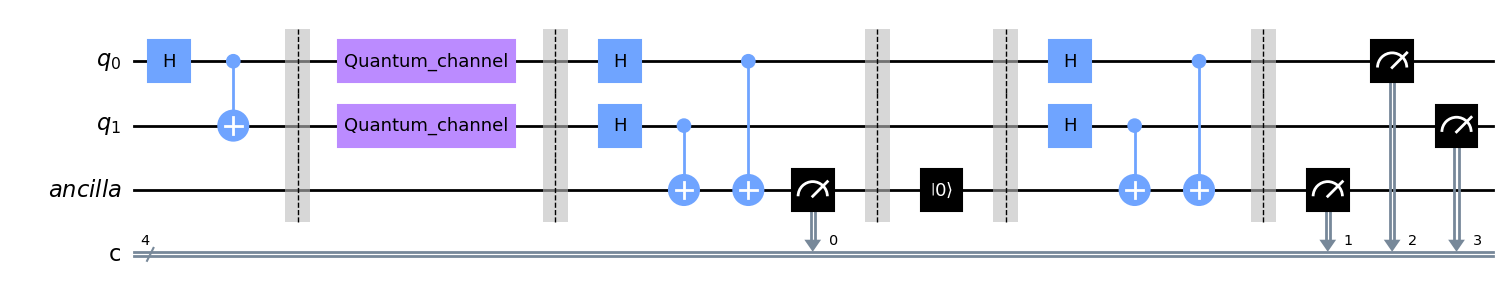

In [32]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, execute, Aer,transpile, assemble
from qiskit.quantum_info import Kraus, SuperOp, Operator, partial_trace, DensityMatrix
from qiskit.visualization import plot_bloch_multivector, plot_state_city,  plot_histogram
from qiskit.providers.aer.noise import amplitude_damping_error, pauli_error, depolarizing_error, NoiseModel, phase_damping_error
from qiskit.quantum_info import DensityMatrix, partial_trace, Pauli
from qiskit_aer import AerSimulator
from qiskit.providers.aer import QasmSimulator
import matplotlib.pyplot as plt
import numpy as np
import math
from IPython.display import Markdown
q = QuantumRegister(2, 'q')

c = ClassicalRegister(4, 'c')
anc = QuantumRegister(1, 'ancilla') 
qc = QuantumCircuit(q,c,anc)
##### Preparation of Initial maximally entangled state:
qc.h(0)
qc.cx(0, 1)
qc.barrier()

# Sending qubits through amplitude damping channel to Charlie
r=0.8 #Damping probability of Amplitude damping
error =amplitude_damping_error(r, excited_state_population=0, canonical_kraus=True)
qc.append(error, [0])
qc.append(error, [1])
qc.barrier()

##### First PC(Z)
qc.h(0)
qc.h(1)
qc.cx(1, 2)
qc.cx(0, 2)
qc.measure([2],c[0])
qc.barrier()

#### Resetting the ancilla qubit
qc.reset(2)
#qc.barrier()
qc.barrier()

#### Second PC(Z)
qc.h(0)
qc.h(1)
qc.cx(1, 2)
qc.cx(0, 2)

################
#Depolarizing error of CNOT gate:
error_rate_cnot =0.05# Adjust this value based on the desired error rate

# Create a depolarizing error for the CNOT gate
cnot_error = depolarizing_error(error_rate_cnot, 2)

#To check that the error rate of the first CNOT gate has no effects on the fidelity you can set a different
#error rate for CNOT [0,1]:
cnot_error1 = depolarizing_error(0.8, 2)
# Create a noise model and add the CNOT error to it for the specified qubits
noise_model = NoiseModel()
noise_model.add_quantum_error(cnot_error, 'cx', [0,2]) 
noise_model.add_quantum_error(cnot_error, 'cx', [1,2])
noise_model.add_quantum_error(cnot_error, 'cx', [0,1])
#noise_model.add_quantum_error(cnot_error1, 'cx', [0,1])
qc.barrier()

#####
qc.measure([2],c[1])
qc.measure([0,1],[2,3])
qc.draw('mpl')

In [33]:
Shots_n=100000
method = "statevector"
backend = AerSimulator(method="statevector")
job = backend.run(qc, method=method, noise_model=noise_model, shots=Shots_n)  # Run the simulation
result = job.result()  # Get the simulation result
counts = result.get_counts()  # Get the measurement counts
print(counts)

{'0110': 5757, '0011': 901, '1100': 20752, '0111': 5474, '1011': 5495, '0001': 13880, '1101': 13893, '0000': 20312, '0101': 976, '1010': 5876, '1000': 1227, '1001': 880, '0100': 1266, '1110': 1233, '0010': 1200, '1111': 878}


Fidelity= 0.9427375925385935


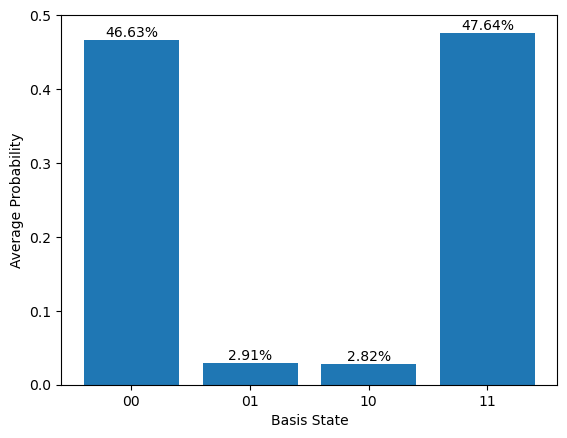

In [34]:
success, fail = 0, 0
Bell_states = {}
Bell_new= {}
for jj in counts:
        if (jj[-1]=='0' and jj[-2]=='0' ): #obtaining phi+
            success += counts[jj]
            Bell_state = jj
            if Bell_state in Bell_states:
                Bell_states[Bell_state] += counts[jj]
            else:
                Bell_states[Bell_state] = counts[jj]
        else:
            fail += counts[jj]
            
total = success + fail

# Extract the last character from each Bell state and store it in Bell_new as a dictionary
for i in Bell_states:
    last_char = i[:2]
    if last_char in Bell_new:
        Bell_new[last_char] += Bell_states[i]
    else:
        Bell_new[last_char] = Bell_states[i]
        

# Convert counts to a sorted list of probabilities
basis_states = ['00', '01', '10', '11']
probabilities = [Bell_new.get(state, 0) / success for state in basis_states] # Normalized state


# Finding fidelity of the output entangled state:
p11 = probabilities[basis_states.index('00')]
p44 = probabilities[basis_states.index('11')]
p14=np.sqrt(p11)*np.sqrt(p44)
Fid=1/2*(p11+p44)+p14
print('Fidelity=',Fid)


# Plot the probabilities as a bar graph
plt.bar(basis_states, probabilities)
plt.xlabel('Basis State')
plt.ylabel('Average Probability')
for i, prob in enumerate(probabilities):
    plt.text(basis_states[i], prob, f'{prob * 100:.2f}%', ha='center', va='bottom')
plt.show()